In [2]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras
from keras_retinanet import models
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# use this to change which GPU to use
gpu = 1

# set the modified tf session as backend in keras
setup_gpu(gpu)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4 Physical GPUs, 1 Logical GPUs


In [6]:
!which python3

/home/alapenok/anaconda3/bin/python3


In [10]:

tf.__version__

'2.1.0'

In [2]:
tensorflow.config.experimental.list_physical_devices('GPU')

NameError: name 'tensorflow' is not defined

In [7]:
! ./keras_retinanet/bin/convert_model.py ~/resnet50_csv_20.h5 model.h5
#! ./convert_model.py ../../resnet50_csv_112.h5 ../../model.h5

Using TensorFlow backend.
2020-06-24 19:51:47.264956: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-24 19:51:47.295824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:18:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2020-06-24 19:51:47.297119: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 1 with properties: 
pciBusID: 0000:3b:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2020-06-24 19:51:47.298326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 2 with properties: 
pciBusID: 0000:5e:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceM

In [13]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('./model','resnet50_custom_origin')
# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
#model = models.convert_model(model)

#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'Гречиха посевная', 1: 'Клевер гибридный', 2: 'Дудник лесной', 3: 'Дудник лекарственный', #
                   4: 'Ива белая', 5: 'Свербига восточная', 6: 'Липа сердцевидная', 7: 'Гвоздика травянка', 
                   8: 'Ольха', 9: 'Береза', 10: 'Иван-чай узколистный'}

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [4]:
import cv2
import numpy as np
from PIL import ImageFont, ImageDraw, Image


def _draw_caption(image, box, caption):
    """ Draws a caption above the box in an image.

    # Arguments
        image   : The image to draw on.
        box     : A list of 4 elements (x1, y1, x2, y2).
        caption : String containing the text to draw.
    """
    b = np.array(box).astype(int)
    image = ImageDraw.Draw(image)
    image.text((b[1], b[0] - 10), caption, fill=(255,255,255))
    
    #cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    #cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)


In [5]:
def crop_image(img, x_side=150, y_side=150):
    """ Crop an image such that the most left an most top part is taken

    Args
        x_side: The number of pixels by x axis starting from the left border.
        y_side: The number of pixels by y axis starting from the top border.

    Returns
        A cropped image.
    """
    #print(img.shape)
    return img[:x_side,:y_side,:]

In [6]:
import pickle

pollen = pickle.load( open( '../../../chudykimg', 'rb' ) )
target = pickle.load( open( '../../../chudyktrgt', 'rb' ) )
nb_classes=target[target.shape[0]-1]+1
#pollen = pollen.astype(np.float32)
#pollen = np.rollaxis(pollen,3,1)
pollen.shape

(600, 160, 160, 3)

94.0 125.0
(188, 250, 3)
Время обработки (мс):  0.08729243278503418
4.25531914893617
Input par draw = [[[249 250 255]
  [251 251 255]
  [249 250 255]
  ...
  [243 251 255]
  [244 250 255]
  [246 248 253]]

 [[248 249 255]
  [248 249 255]
  [249 250 255]
  ...
  [244 251 255]
  [248 249 255]
  [246 249 255]]

 [[248 249 255]
  [249 250 255]
  [249 250 255]
  ...
  [246 250 255]
  [246 250 255]
  [244 251 255]]

 ...

 [[251 252 251]
  [251 252 251]
  [251 252 251]
  ...
  [255 255 255]
  [229 237 232]
  [234 243 246]]

 [[251 252 251]
  [251 252 251]
  [251 251 253]
  ...
  [231 239 231]
  [217 229 221]
  [241 244 249]]

 [[251 252 251]
  [251 252 251]
  [251 251 251]
  ...
  [239 243 246]
  [243 245 248]
  [248 249 255]]]  type <class 'numpy.ndarray'> 
                 Input par b = [213, 137, 246, 173]  type <class 'list'> 
                 Input par color = [0, 159, 255]  type <class 'list'>

(188, 250, 3)
(300, 4)
Клевер гибридный 0.96
Изображение содержит 1 пыльцевых зерен вида Кле

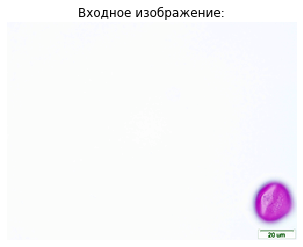

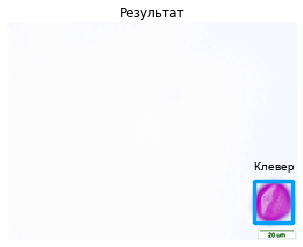

In [111]:


path ='110.png'
#image = read_image_bgr('../../../retinanetio/ds11/'+ path)
image = read_image_bgr('../custom_dataset/ds11/'+ path)
#num = 361
#image = pollen[num]
# copy to draw on
#image = image[:, :, ::-1].copy()
# image = crop_image(image, int(image.shape[0]/2), int(image.shape[1]/2))
draw = image.copy()

draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
print(image.shape[0]/2, image.shape[1]/2)

print(image.shape)
image, scale = resize_image(image)
fig, ax = plt.subplots()
ax.set_title("Входное изображение:")


plt.axis('off')

ax.imshow(draw)

# process image
start = time.time()
image.shape
boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
print("Время обработки (мс): ", time.time() - start)

# correct for image scale
print(scale)
boxes /= scale

# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    b = box.astype(int)
    #print(b)
    b=[b[0],b[1],b[2],b[3]]
    #print(b)
    print(f"Input par draw = {draw}  type {type(draw)} \n \
                Input par b = {b}  type {type(b)} \n \
                Input par color = {color}  type {type(color)}\n")    
    draw_box(draw, b, color=color)
counter = 0
plant = ""
print(draw.shape)
draw= Image.fromarray(draw.astype('uint8'))
im = ImageDraw.Draw(draw, 'RGB')

for box, score, label in zip(boxes[0], scores[0], labels[0]):
# scores are sorted so we can break
    if score < 0.5:
        break
    counter+=1
    print(boxes[0].shape)
    plant = labels_to_names[label]
    color = label_color(label)
    b = box.astype(int)
    
    b=[b[1],b[0],b[3],b[2]]
    font=ImageFont.truetype("../ARIALUNI.TTF",10)
    caption = "{} {:.2f}".format(labels_to_names[label], score)
    print("{} {:.2f}".format(labels_to_names[label], score))
    im.text((b[1], b[0] - 20), caption, font=font, fill=(0,0,0))
    
fig, ax = plt.subplots()
plt.axis('off')

print("Изображение содержит {} пыльцевых зерен вида {}".format(counter, plant))
ax.set_title("Результат")
ax.imshow(np.asarray(draw, dtype='uint8'))

plt.show()
#plt.savefig("result_"+path)


[4.25531914893617, 4.25531914893617, 4.25531914893617, 4.25531914893617, 4.25531914893617]
[[[ 7.6337598e+02  4.3429947e+02  1.0630000e+03  7.2005237e+02]
  [ 7.6512585e+02  4.3535748e+02  1.0599677e+03  7.2172583e+02]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
  ...
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]]

 [[ 7.6426617e+02  4.4421085e+02  1.0404711e+03  7.3347906e+02]
  [ 7.6426617e+02  4.4421085e+02  1.0404711e+03  7.3347906e+02]
  [ 7.6872131e+02  4.4616559e+02  1.0422284e+03  7.3265924e+02]
  ...
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]
  [-1.0000000e+00 -1.0000000e+00 -1.0000000e+00 -1.0000000e+00]]

 [[ 7.7865515e+02  4.4588107e+02  1.0365510e+03  7.2426569e+02]
  [ 7.8047290e+02  4.4593536e+02  1.0364594e+03  7.2760120e+0

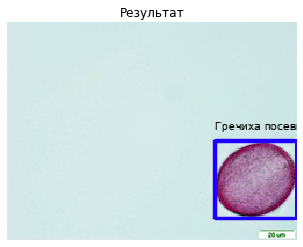

Гречиха посевная 0.98
Изображение 1 содержит пыльцевых зерен:
Гречиха посевная: 1


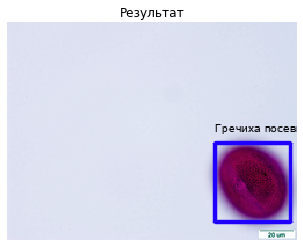

Гречиха посевная 0.97
Изображение 2 содержит пыльцевых зерен:
Гречиха посевная: 1


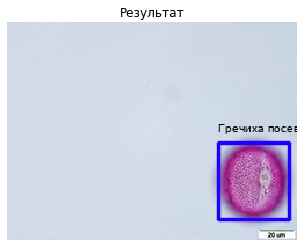

Гречиха посевная 0.95
Изображение 3 содержит пыльцевых зерен:
Гречиха посевная: 1


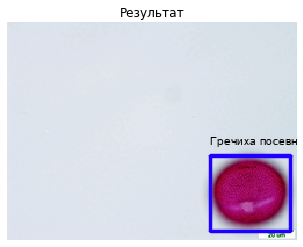

Гречиха посевная 0.98
Изображение 4 содержит пыльцевых зерен:
Гречиха посевная: 1


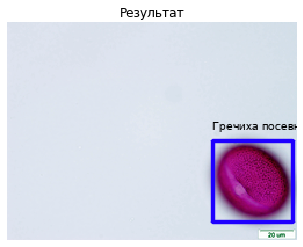

ИТОГО: Набор изображений содержит 5 пыльцевых зерен, из которых
Гречиха посевная: 5


''

In [19]:
from collections import Counter
from fpdf import FPDF
import datetime 
date_time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
pdf = FPDF()
pdf.add_font('arial', '', '../ARIALUNI.TTF', uni=True) 
pdf.add_page()
pdf.set_font("arial", size=10)
pdf.cell(200, 10, txt="ОТЧЕТ ОТ " + date_time, ln=1, align="C")


images = []
draws = []
scales = []
for i in range(0,5):
    image = read_image_bgr('../custom_dataset/ds11/'+ str(i)+'.png')
    # preprocess image for network
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    image = preprocess_image(image)
    draws.append(draw)
    image, scale = resize_image(image)
    scales.append(scale)
#     fig, ax = plt.subplots()
#     ax.set_title("Входное изображение:")
#     plt.axis('off')
#     ax.imshow(draw)
    images.append(image)
    
images = np.array(images)

# process image
start = time.time()
# print(images.shape)
boxes, scores, labels = model.predict_on_batch(images)
# print("Время обработки (мс): ", time.time() - start)
processing_time = time.time() - start
# correct for image scale
print(scales)
print(boxes)
for j in range(len(scales)):
    boxes[j,:,:] /= scales[j] #источник бага, scale надо хранить в массиве

font = ImageFont.truetype("../ARIALUNI.TTF",10)
global_counter = 0
plant = ""
# print(len(draws))
# print(boxes.shape)
# visualize detections
for i,d in enumerate(draws):        
    draw = d
    counter = 0
    for box, score, label in zip(boxes[i], scores[i], labels[i]):
        # scores are sorted so we can break
        if score < 0.5:
            break
        color = label_color(label)
        draw_box(draw, box, color=color)
    draw = Image.fromarray(draw.astype('uint8'))
    im_draw = ImageDraw.Draw(draw, 'RGB')

    for box, score, label in zip(boxes[i], scores[i], labels[i]):    
        # scores are sorted so we can break
        if score < 0.5:
            break    
        
        plant = labels_to_names[label]
        caption = "{} {:.2f}".format(plant, score)
        print("{} {:.2f}".format(plant, score))
        b = box.astype(int)
        im_draw.text((b[0], b[1] - 20), caption, font=font, fill=(0,0,0))    
        counter += 1
    global_counter += counter    
    fig, ax = plt.subplots()
    plt.axis('off')
    print("Изображение {} содержит пыльцевых зерен:".format(i))
    pdf.cell(200, 10, txt="Изображение {} содержит пыльцевых зерен:".format(i), ln=1, align="L")
#     print(labels[i])
    for key, count in Counter(labels[i][scores[i]>.5]).most_common():
        print ('{}: {}'.format(labels_to_names[int(key)],count))
        pdf.cell(200, 10, txt='{}: {}'.format(labels_to_names[int(key)],count), ln=1, align="L")
    ax.set_title("Результат")
    ax.imshow(np.asarray(draw, dtype='uint8'))

    plt.show()
print("ИТОГО: Набор изображений содержит {} пыльцевых зерен, из которых".format(len(labels[scores>.5])))
pdf.cell(200, 10, txt="______________________________________________________",
        ln=1, align="L") 
pdf.cell(200, 10, txt="ИТОГО: Набор изображений содержит {} пыльцевых зерен, из которых".format(len(labels[scores>.5])),
        ln=1, align="L")                 
for key, count in Counter(labels[scores>.5]).most_common():
    print ('{}: {}'.format(labels_to_names[int(key)],count))
    pdf.cell(200, 10, txt='{}: {}'.format(labels_to_names[int(key)],count), ln=1, align="L")  
pdf.cell(200, 10, txt="Время обработки изображений (мс): " + str(processing_time), ln=1, align="L")
report_name = "report-" + date_time + ".pdf"   
pdf.output(report_name)

In [127]:
spectrum = map(lambda x: labels_to_names[x],labels[scores>.5])
list(spectrum)

['Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная',
 'Гречиха посевная']

In [136]:
import PyPDF2

In [32]:
! python3 keras_retinanet/bin/evaluate.py --gpu 2 --save-path ./evaluation_results csv ../pollen-SEM/bboxes.csv ../pollen-SEM/class_map.csv model.h5

Using TensorFlow backend.
2020-06-24 21:30:45.883893: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-06-24 21:30:45.916283: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:5e:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2020-06-24 21:30:45.916781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-06-24 21:30:45.919178: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-06-24 21:30:45.922395: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-06-24 21:30:45.922991: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened d

In [ ]:
! pip3 install tensorflow